# Final Summary Notebook
Final findings from the ranking systems.

In [1]:
# Initialise a spark session
import pandas as pd
from collections import Counter
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.regression import RandomForestRegressionModel, GBTRegressionModel
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from pyspark.sql import Window
import numpy as np

spark = (
    SparkSession.builder.appName("Final Summary")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "8g")  
    .config("spark.executor.memory", "8g") 
    .config("spark.executor.instances", "4")  
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
)

24/10/03 14:29:43 WARN Utils: Your hostname, Melissas-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.13.81.45 instead (on interface en0)
24/10/03 14:29:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/03 14:29:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [28]:
rf_model = RandomForestRegressionModel.load("../models/random_forest_model")
gbt_model = GBTRegressionModel.load("../models/gbt_model")

In [3]:
transactions = spark.read.parquet('../data/curated/flagged_fraud')

## Comparing Models Feature Importance

In [29]:
rf_importances = rf_model.featureImportances
rf_importance_values = rf_importances.toArray()

In [30]:
# Adjust feature columns to account for expanded features
final_df = spark.read.parquet('../data/curated/final_df.parquet/')


# Assuming you have the following feature columns before encoding and scaling
original_feature_cols = [
    'monthly_revenue', 'transaction_count', 'avg_fraud_probability_merchant', 'avg_unemployment_rate',
    'state_consumer_encoded', 'gender_consumer_encoded', 'revenue_growth', 'category_encoded', 'revenue_band_encoded',
    'avg_take_rate'
]

# Determine the size of each OneHotEncoded column
encoded_sizes = {
    'state_consumer_encoded': 7,  # Example, adjust based on your data
    'gender_consumer_encoded': 3,
    'category_encoded': 25,
    'revenue_band_encoded': 5
}

# Manually expand the encoded feature columns
expanded_feature_names = []

for col in original_feature_cols:
    if col in encoded_sizes:
        # For OneHotEncoded features, append the individual components
        expanded_feature_names += [f"{col}_{i}" for i in range(encoded_sizes[col])]
    else:
        # For regular numeric features, just append the column name
        expanded_feature_names.append(col)


# Extract feature importances for Random Forest
rf_importances = rf_model.featureImportances.toArray()

# Extract feature importances for GBT
gbt_importances = gbt_model.featureImportances.toArray()

# Create DataFrame for Random Forest feature importance
rf_feature_importance_df = pd.DataFrame({
    'Feature': expanded_feature_names[:len(rf_importances)],  # Ensure the feature list matches importance values
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False).head(10)  # Select top 10 important features

# Create DataFrame for GBT feature importance
gbt_feature_importance_df = pd.DataFrame({
    'Feature': expanded_feature_names[:len(gbt_importances)],  # Ensure the feature list matches importance values
    'Importance': gbt_importances
}).sort_values(by='Importance', ascending=False).head(10)  # Select top 10 important features


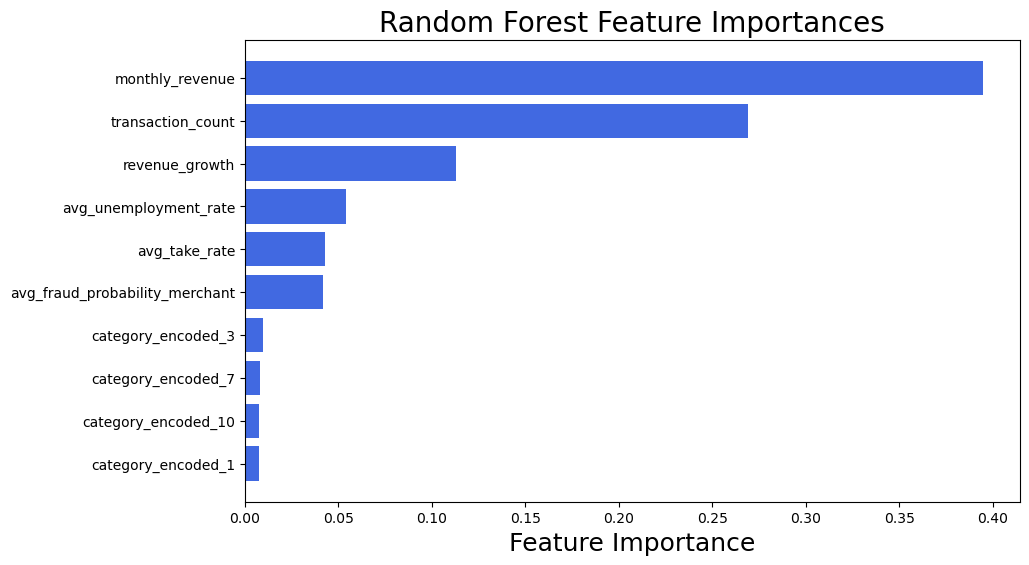

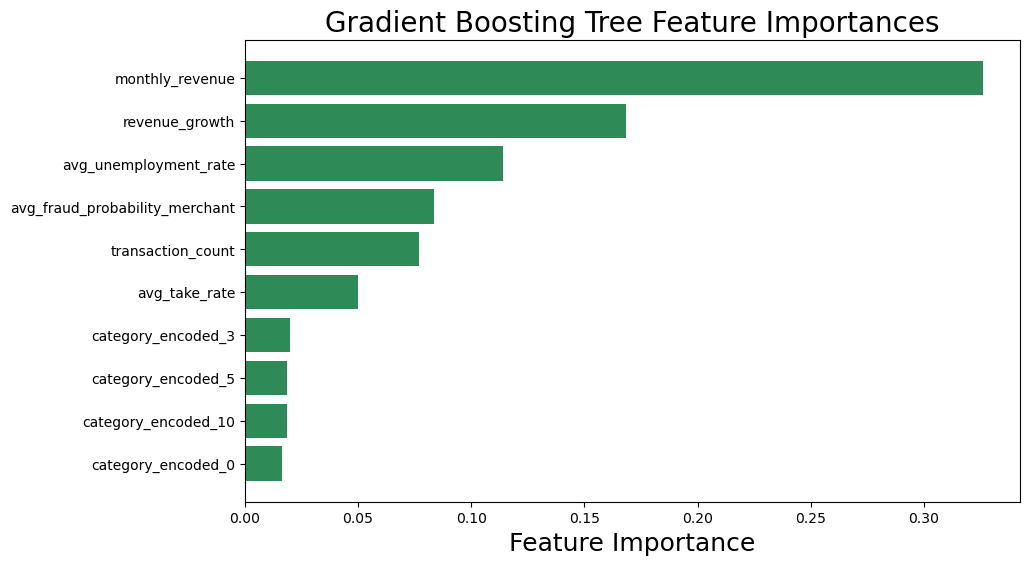

In [39]:
# Random Forest
plt.figure(figsize=(10, 6))
plt.barh(rf_feature_importance_df['Feature'], rf_feature_importance_df['Importance'], color='royalblue')
plt.xlabel('Feature Importance', fontsize=18)
plt.title('Random Forest Feature Importances', fontsize=20)
plt.gca().invert_yaxis()  # To have the highest importance on top
plt.show()

# GBT
plt.figure(figsize=(10, 6))
plt.barh(gbt_feature_importance_df['Feature'], gbt_feature_importance_df['Importance'], color='seagreen')
plt.xlabel('Feature Importance', fontsize=18)
plt.title('Gradient Boosting Tree Feature Importances', fontsize=20)
plt.gca().invert_yaxis()  # To have the highest importance on top
plt.show()

The encoded categories referred to are:

For Random Forest Model:
* Category for category_encoded_3: computer programming , data processing, and integrated systems design services
* Category for category_encoded_7: florists supplies, nursery stock, and flowers
* Category for category_encoded_10: furniture, home furnishings and equipment shops, and manufacturers, except appliances
* Category for category_encoded_1: digital goods: books, movies, music

For GBT Model:
* Category for category_encoded_3: gift, card, novelty, and souvenir shops
* Category for category_encoded_5: cable, satellite, and other pay television and radio services
* Category for category_encoded_10: furniture, home furnishings and equipment shops, and manufacturers, except appliances
* Category for category_encoded_0: tent and awning shops

In both models, the category of furniture segment is in the top 10 important features, meaning that being in the industry likely would have a bigger impact on projected monthly revenue.
It is also interesting to note that the top 10 features in both models are relatively similar.

## Evaluating Frauds in Categories
Looking at the distribution of number of transactions marked as fraud, there seems to be a high number in the tent segment. This could imply a difference of market characteristics in the tent segment in comparison to the other segments, or be a true indication that there are more fraudulent transactions in that segmentation.

/var/folders/nb/ptvngvk147s5wfkvdykjdlvm0000gn/T/ipykernel_28377/2777900153.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to prevent clipping of labels


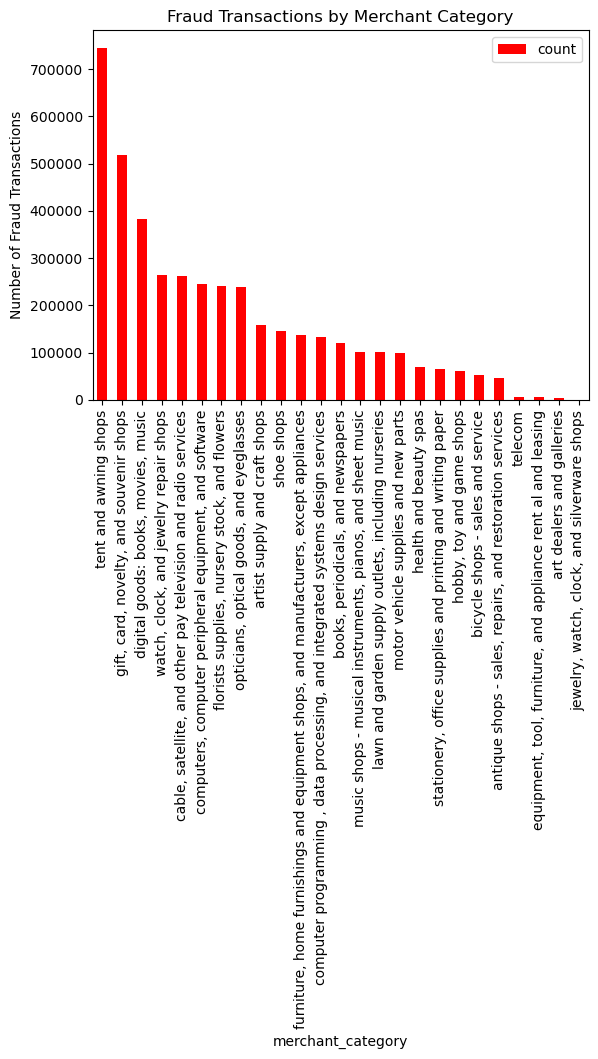

In [7]:
# Fraud transactions by merchant category
fraud_category = transactions.filter("is_fraud == true").groupBy("merchant_category").count()
fraud_category_df = fraud_category.orderBy(F.desc("count")).toPandas()

fraud_category_df.plot(kind='bar', x='merchant_category', y='count', color='red')
plt.title("Fraud Transactions by Merchant Category")
plt.ylabel("Number of Fraud Transactions")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Close the previous plot to avoid any overlap
plt.close()

## Distinct Fraud Probability Distributions between Consumer and Merchants
Looking at the distribution of fraud probability between consumers and merchants, there is a clearly different distribution. More merchants are scored with a higher fraud probability than consumers.

24/10/01 16:28:25 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


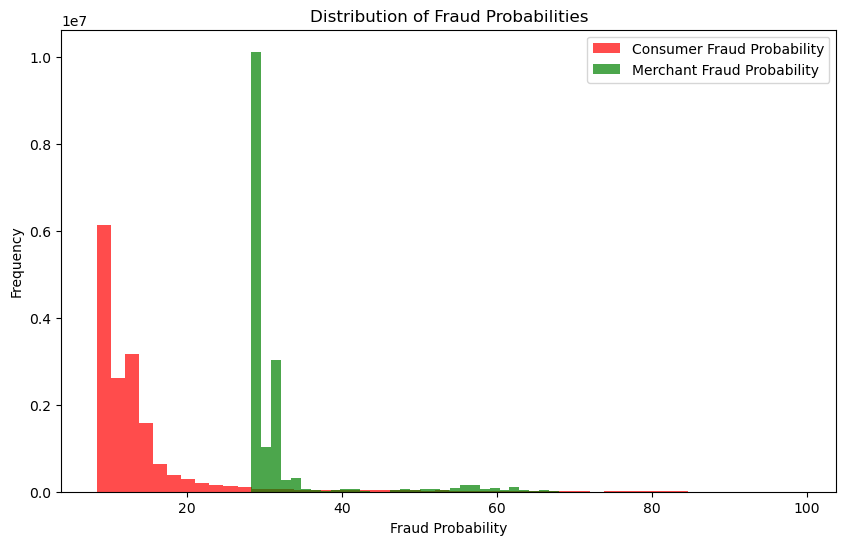

In [8]:
df_pandas_fraud_prob = transactions.select("fraud_probability_consumer", "fraud_probability_merchant").toPandas()

plt.figure(figsize=(10,6))
plt.hist(df_pandas_fraud_prob['fraud_probability_consumer'], bins=50, color='red', alpha=0.7, label="Consumer Fraud Probability")
plt.hist(df_pandas_fraud_prob['fraud_probability_merchant'], bins=50, color='green', alpha=0.7, label="Merchant Fraud Probability")
plt.xlabel('Fraud Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Fraud Probabilities')
plt.legend()
plt.show()


## Comparing Overall Top 100 Merchant Rankings (Random Forest vs. GBT Model)

In [2]:
RF_ranking = spark.read.parquet('../data/curated/RF_ranking')
GBT_ranking = spark.read.parquet('../data/curated/GBT_ranking')

24/10/03 14:29:55 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


### Spearman's Rank Correlation
Measures the degree of similarity between the two rankings. Higher values close to 1 indicate that the rankings are similar.

In [10]:
# Perform the inner join
prediction_comparison = RF_ranking.alias("rf").join(
    GBT_ranking.alias("gbt"),
    on="merchant_abn",
    how="inner"
).select(
    F.col("merchant_abn"),
    F.col("rf.projected_revenue").alias("RF_rank"),
    F.col("gbt.projected_revenue").alias("GBT_rank")
)

predictions_pandas = prediction_comparison.toPandas()
spearman_corr, p_value = spearmanr(predictions_pandas['RF_rank'], predictions_pandas['GBT_rank'])

print(f"Spearman Rank Correlation: {spearman_corr}")


Spearman Rank Correlation: 0.8287428808691683


In [11]:
RF_ranking.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- future_order_month_year: string (nullable = true)
 |-- projected_revenue: double (nullable = true)
 |-- RF_rank: integer (nullable = true)



### Overlap in Top 100 Merchants

In [3]:
# Select top K merchants from each ranking
K = 100
RF_top_k = RF_ranking.orderBy(F.asc("projected_revenue")).limit(K).select("merchant_abn")
GBT_top_k = GBT_ranking.orderBy(F.asc("projected_revenue")).limit(K).select("merchant_abn")

# Find the intersection of the two sets (common merchants in the top K)
common_top_k = RF_top_k.intersect(GBT_top_k)

# Calculate the percentage of overlap
common_count = common_top_k.count()
overlap_percentage = (common_count / K) * 100

print(f"Top {K} Overlap: {common_count} merchants ({overlap_percentage:.2f}%)")

Top 100 Overlap: 91 merchants (91.00%)


### Overlap in Top 100 Merchants and Merchants with Lowest Fraud Probability

In [10]:
least_fraud = spark.read.csv('../data/curated/top_100_merchants_xgb.csv', header=True)
least_fraud.show(10)

+------------+---------------------+
|merchant_abn|fraud_probability_xgb|
+------------+---------------------+
| 37459245212|        0.00020802586|
| 46804135891|        0.00021442682|
| 17324645993|         0.0002267606|
| 39896913161|        0.00024810398|
| 64203420245|        0.00024810398|
| 62694031334|        0.00024810398|
| 29566626791|        0.00024810398|
| 43186523025|        0.00024810398|
| 45629217853|        0.00024810398|
| 73895811023|        0.00024810398|
+------------+---------------------+
only showing top 10 rows



In [11]:
common = RF_top_k.intersect(least_fraud.orderBy(F.asc("fraud_probability_xgb")).limit(K).select("merchant_abn"))

percentage = (common.count() / K) * 100

print(f"Top {K} Overlap: {common.count()} merchants ({percentage:.2f}%)")

Top 100 Overlap: 22 merchants (22.00%)


24/10/03 15:45:44 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 308534 ms exceeds timeout 120000 ms
24/10/03 15:45:44 WARN SparkContext: Killing executors is not supported by current scheduler.
24/10/03 15:45:46 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

Looking at the spearman rank correlation and ranking overlap, we can see that the Random Forest and Gradient Boosted Tree models produced a very similar ranking output.

### Overlap in Segmentation Top 10 Merchants and Overall Top 100 Merchants
Do the top 10 merchants ranked in the specific segment model appear in the overall top 100 merchants?

In [13]:
# Load Rankings for Merchant Categories
computers = spark.read.parquet('../data/curated/top_10_computers')
furnitures = spark.read.parquet('../data/curated/top_10_furniture')
florists = spark.read.parquet('../data/curated/top_10_florists')

In [14]:
computers_commons = computers.select("merchant_abn").intersect(RF_top_k)
computers_overlap = (computers_commons.count() / 10) * 100

furnitures_commons = furnitures.select("merchant_abn").intersect(RF_top_k)
furnitures_overlap = (furnitures_commons.count() / 10) * 100

florists_commons = florists.select("merchant_abn").intersect(RF_top_k)
florists_overlap = (florists_commons.count() / 10) * 100

In [15]:
print(f"Computer ranking overlap percentage: {computers_overlap}")
print(f"Furniture ranking overlap percentage: {furnitures_overlap}")
print(f"Florist ranking overlap percentage: {florists_overlap}")

Computer ranking overlap percentage: 0.0
Furniture ranking overlap percentage: 50.0
Florist ranking overlap percentage: 60.0


Interestingly, the top 10 merchants from the computers category has zero overlap with the top 100 merchants overall ranking. This could indicate that merchants in the computers category may have relatively high average order values but a lower volume of transactions. This suggests that while each transaction may be large in dollar value, the overall number of transactions is smaller compared to other merchants. This is a typical pattern for industries like electronics, where the per-unit price is higher, but the frequency of purchases is lower compared to, for example, retail or fast-moving consumer goods. The top 100 merchants by projected monthly revenue may be dominated by merchants in other categories with higher transaction volumes. This implies that categories with lower average order values but more frequent purchases (e.g., retail, beauty, or fast fashion) contribute significantly to overall revenue. This will be explored further in the following sections.

## Revenue vs. Category

/var/folders/nb/ptvngvk147s5wfkvdykjdlvm0000gn/T/ipykernel_1660/1575580455.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

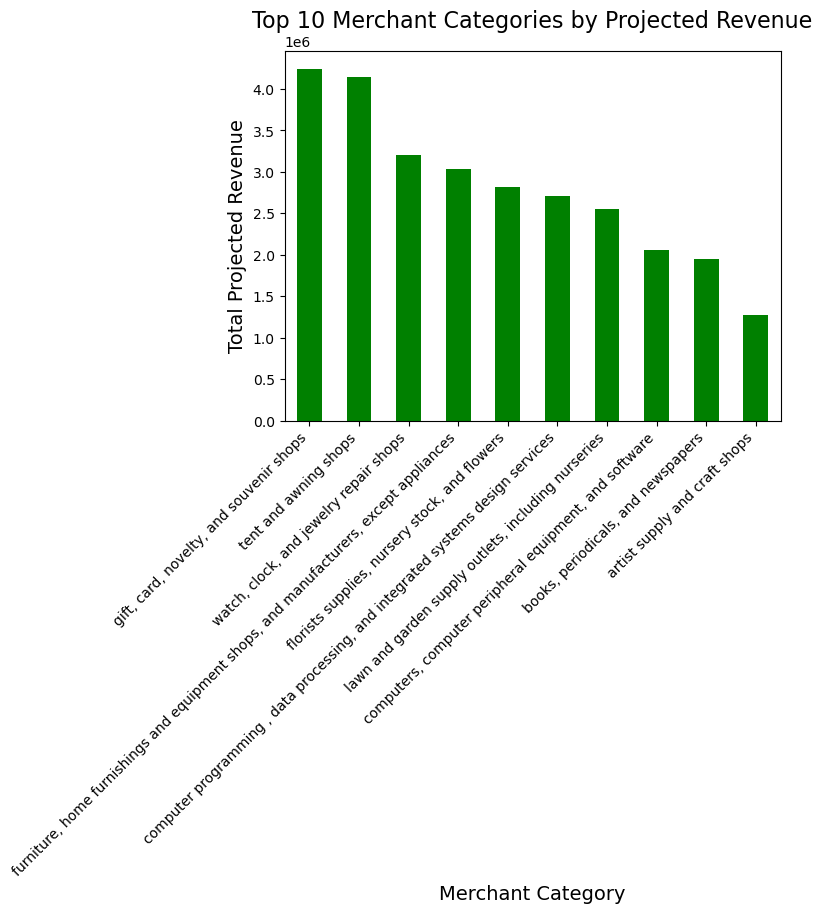

In [8]:
# Group by merchant category and calculate total projected revenue
category_revenue = RF_ranking.groupBy("merchant_category") \
    .agg(F.sum("projected_revenue").alias("total_projected_revenue")) \
    .orderBy(F.desc("total_projected_revenue"))

# Convert to Pandas for plotting
category_revenue_pd = category_revenue.toPandas()

# Plot the top 10 categories by total projected revenue
plt.figure(figsize=(10, 6))
category_revenue_pd[:10].plot(kind='bar', x='merchant_category', y='total_projected_revenue', legend=False, color='green')

# Set plot title and labels
plt.title('Top 10 Merchant Categories by Projected Revenue', fontsize=16)
plt.xlabel('Merchant Category', fontsize=14)
plt.ylabel('Total Projected Revenue', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()

## Merchant Category and Rankings

In [26]:
category_count = RF_ranking.groupBy('merchant_category') \
    .agg(F.count('merchant_abn').alias('merchant_count')) \
    .orderBy(F.desc('merchant_count'))

category_count.show(truncate=False, n=25)

+-------------------------------------------------------------------------------------+--------------+
|merchant_category                                                                    |merchant_count|
+-------------------------------------------------------------------------------------+--------------+
|tent and awning shops                                                                |11            |
|gift, card, novelty, and souvenir shops                                              |8             |
|lawn and garden supply outlets, including nurseries                                  |8             |
|watch, clock, and jewelry repair shops                                               |7             |
|books, periodicals, and newspapers                                                   |7             |
|florists supplies, nursery stock, and flowers                                        |7             |
|computers, computer peripheral equipment, and software                  

## Plotting Correlation of Heuristic Features
Looking at the correlation of specific features used in merchant segment ranking and the feature used in overall merchant ranking.

### Customer Repeat Ratio vs. Projected Revenue
This plot shows that customer repeat ratio and projected monthly revenue has a highly positive relationship that is somewhat linear. The plot suggests that having a loyal customer base would increase the chances of growing monthly revenue.

In [34]:
window_spec = Window.partitionBy('merchant_abn', 'user_id')

# Calculate the number of transactions per user and flag repeat customers
repeat_customers_df = transactions.withColumn(
    'user_transactions', F.count('order_id').over(window_spec)
).withColumn(
    'is_repeat_customer', F.when(F.col('user_transactions') > 1, 1).otherwise(0)
)

# Aggregate repeat customer ratio and total revenue for each merchant
merchant_behavior_df = repeat_customers_df.groupBy('merchant_abn').agg(
    F.avg('is_repeat_customer').alias('repeat_customer_ratio'),
    F.sum('dollar_value').alias('total_revenue')
)

merchant_behavior_ranking_df = merchant_behavior_df.join(
    RF_ranking, on='merchant_abn', how='inner'
).select('merchant_abn', 'merchant_name', 'repeat_customer_ratio', 'total_revenue', 'projected_revenue')

merchant_behavior_ranking_pd = merchant_behavior_ranking_df.toPandas()

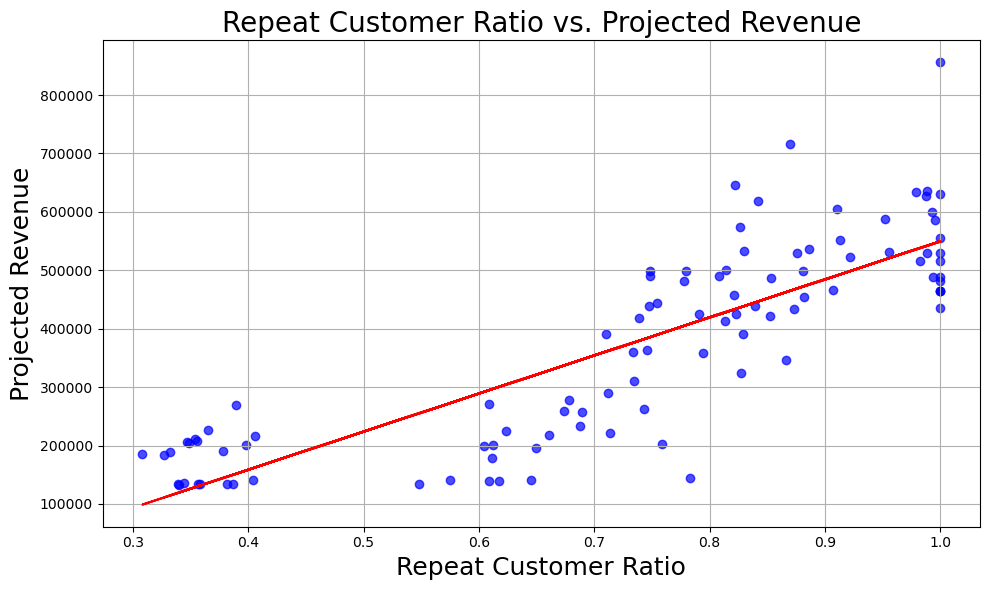

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(merchant_behavior_ranking_pd['repeat_customer_ratio'], merchant_behavior_ranking_pd['projected_revenue'], color='blue', alpha=0.7)

# Calculate and plot trendline
z = np.polyfit(merchant_behavior_ranking_pd['repeat_customer_ratio'], merchant_behavior_ranking_pd['projected_revenue'], 1)
p = np.poly1d(z)
plt.plot(merchant_behavior_ranking_pd['repeat_customer_ratio'], p(merchant_behavior_ranking_pd['repeat_customer_ratio']), color='red', label='Trendline')

plt.xlabel('Repeat Customer Ratio', fontsize=18)
plt.ylabel('Projected Revenue', fontsize=18)
plt.title('Repeat Customer Ratio vs. Projected Revenue', fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

### Annual AOV vs. Projected Monthly Revenue (Computers)
Looking at this plot, it's clear why the top 10 merchants for computers does not overlap with the top 100 merchants overall, as the heuristic feature used in ranking computer merchants (Annual AOV) is not reflected in the projected monthly revenue feature. The plot suggests that merchants with high annual AOV do not necessarily have the highest projected monthly revenue. This can be because merchants with higher AOVs might have fewer transactions. 

In [8]:
from pyspark.sql.functions import lower, col

computer_transactions = transactions.filter(lower(col("merchant_category")).contains("computers"))

annual_avg_order_value_df = computer_transactions.groupBy('merchant_abn').agg(
    (F.sum('dollar_value') / F.countDistinct('year_week')).alias('annual_avg_order_value')
)

# Step 3: Join the annual average order value with the RF ranking
merchant_order_value_ranking_df = annual_avg_order_value_df.join(
    RF_ranking.filter(F.lower(F.col('merchant_category')).like('%computers%')), 
    on='merchant_abn', 
    how='inner'
).select('merchant_abn', 'merchant_name', 'annual_avg_order_value', 'projected_revenue')

# Step 4: Convert to Pandas for visualization
merchant_order_value_ranking_pd = merchant_order_value_ranking_df.toPandas()

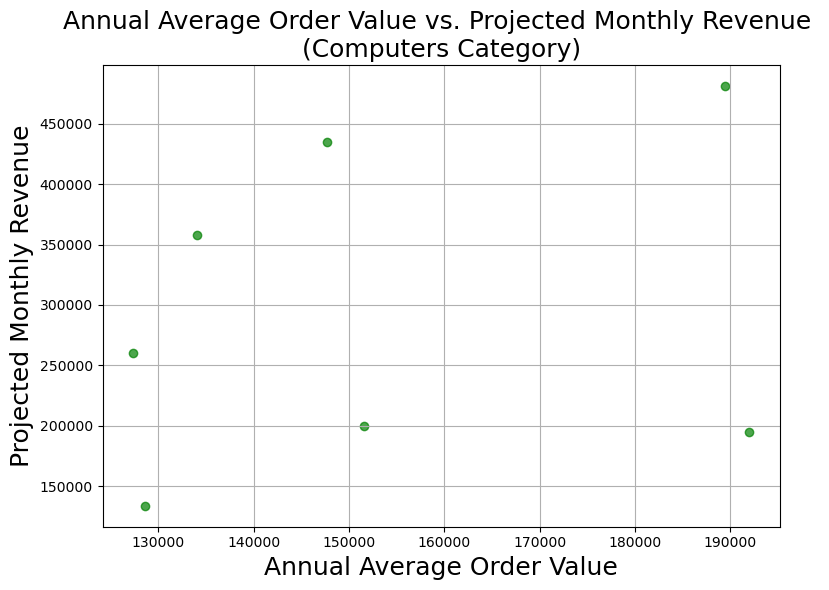

In [13]:
plt.figure(figsize=(8, 6))

plt.scatter(merchant_order_value_ranking_pd['annual_avg_order_value'], merchant_order_value_ranking_pd['projected_revenue'], color='green', alpha=0.7)

plt.xlabel('Annual Average Order Value', fontsize=18)
plt.ylabel('Projected Monthly Revenue', fontsize=18)
plt.title('Annual Average Order Value vs. Projected Monthly Revenue \n(Computers Category)', fontsize=18)
plt.grid(True)
plt.tight_layout()

plt.show()

# Display Rankings
Due to model evaluation metrics computed, we will use the rankings based on the random forest regressor model.

## Top 100 Merchants Based on RF Model

In [21]:
RF_ranking.show(truncate=False, n=100)

+------------+---------------------------------+-------------------------------------------------------------------------------------+-----------------------+------------------+-------+
|merchant_abn|merchant_name                    |merchant_category                                                                    |future_order_month_year|projected_revenue |RF_rank|
+------------+---------------------------------+-------------------------------------------------------------------------------------+-----------------------+------------------+-------+
|86578477987 |Leo In Consulting                |watch, clock, and jewelry repair shops                                               |Aug-24                 |855832.058105619  |1      |
|52959528548 |Libero Et Limited                |furniture, home furnishings and equipment shops, and manufacturers, except appliances|Aug-24                 |715938.8988212582 |2      |
|90543168331 |Phasellus Dapibus Incorporated   |furniture, home furnis

## Top 10 Computer Merchants

In [17]:
computers.show(truncate=False)

+------------+----------------------------+------------------------------------------------------+----------+--------------------+-------------+
|merchant_abn|merchant_name               |merchant_category                                     |order_year|projected_annual_aov|computer_rank|
+------------+----------------------------+------------------------------------------------------+----------+--------------------+-------------+
|87898093521 |Donec Felis Orci Corporation|computers, computer peripheral equipment, and software|2023      |619.7345978210113   |1            |
|65453072511 |Vehicula Aliquet LLC        |computers, computer peripheral equipment, and software|2023      |605.8739807168172   |2            |
|87122475882 |Lectus Sit Incorporated     |computers, computer peripheral equipment, and software|2023      |595.4567889255605   |3            |
|34048570533 |Interdum Libero Dui Company |computers, computer peripheral equipment, and software|2023      |573.3801440709956   |

## Top 10 Florist Merchants

In [18]:
florists.show(truncate=False)

+------------+------------------------------+---------------------------------------------+----------+---------------------------+------------+
|merchant_abn|merchant_name                 |merchant_category                            |order_year|projected_return_cust_ratio|florist_rank|
+------------+------------------------------+---------------------------------------------+----------+---------------------------+------------+
|21772962346 |Purus Gravida Sagittis Ltd    |florists supplies, nursery stock, and flowers|2023      |0.2511447344534246         |1           |
|33607911449 |Nulla Semper LLC              |florists supplies, nursery stock, and flowers|2023      |0.2375029455767293         |2           |
|80682333501 |Orci Corp.                    |florists supplies, nursery stock, and flowers|2023      |0.2364512226890664         |3           |
|80982848464 |Tempor Augue Limited          |florists supplies, nursery stock, and flowers|2023      |0.22618991912893954        |4     

## Top 10 Furniture Merchants

In [19]:
furnitures.show(truncate=False)

+------------+------------------------------+-------------------------------------------------------------------------------------+----------+----------------------+--------------+
|merchant_abn|merchant_name                 |merchant_category                                                                    |order_year|projected_total_orders|furniture_rank|
+------------+------------------------------+-------------------------------------------------------------------------------------+----------+----------------------+--------------+
|38090089066 |Interdum Feugiat Sed Inc.     |furniture, home furnishings and equipment shops, and manufacturers, except appliances|2023      |27468.385416666668    |1             |
|52959528548 |Libero Et Limited             |furniture, home furnishings and equipment shops, and manufacturers, except appliances|2023      |19661.835416666665    |2             |
|76767266140 |Phasellus At Limited          |furniture, home furnishings and equipment shops, a

In [4]:
RF_ranking.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- future_order_month_year: string (nullable = true)
 |-- projected_revenue: double (nullable = true)
 |-- RF_rank: integer (nullable = true)

